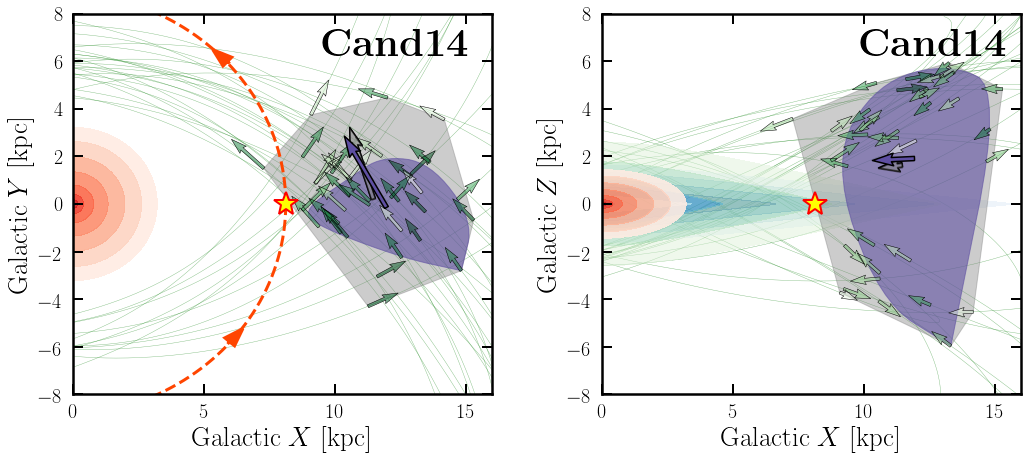

In [7]:
from numpy import *
from numpy.random import *
from PlotFuncs import *
import pandas

# Load all stars
df = pandas.read_csv('../data/GAIA_SDSS_Shards.csv')
names = df.group_id.unique()
num_cands = size(names)

name = 'Cand14'
Cand = df.loc[df['group_id'] == name].reset_index()

if name=='C2':
    Cand = Cand[(Cand.GalRVel<0)&(Cand.GalzVel>100)]

#fig = VelocityTriangle(Cand,RemoveOutliers=True,SaveFigure = True,PlotFullSample=True)
#plt.show()
#plt.close(fig)


colsubs = flipud(cm.Spectral(linspace(0.0,1.0,num_cands)))
fig = XY_XZ(Cand,StarsColour=colsubs[0,:],Grid=False,Footprint=False)
plt.show()
plt.close(fig)

In [4]:
Cand.feh

0    -1.415835
1    -1.389932
2    -1.112181
3    -1.644808
4    -1.151293
5    -1.354360
6    -1.250862
7    -1.474290
8    -1.620511
9    -1.463091
10   -1.587761
11   -1.360384
12   -1.368916
13   -1.489727
14   -1.383256
15   -1.508650
16   -1.293658
17   -1.164840
18   -1.512721
19   -1.159643
20   -1.488063
21   -1.346413
22   -1.673997
23   -1.635905
24   -1.305995
25   -1.337172
26   -1.240579
27   -1.404804
28   -1.668480
29   -1.485612
30   -1.359814
31   -1.437333
32   -1.647550
33   -2.056713
34   -1.447351
35   -1.927534
Name: feh, dtype: float64

In [74]:

# SAVING DATA

# Set up data frames
params = ['x','y','z','dx','dy','dz','vx','vy','vz','sigx','sigy','sigz','feh','dfeh','population','Psun']
nparams = size(params)
dat = zeros(shape=(1,nparams))
df_shards = pandas.DataFrame(dat,columns=params)
shard_names = ' '

# Loop over shards
for i_cand in range(0,num_cands):
    # Get shard
    Cand = df.loc[df['group_id'] == names[i_cand]]
        
    if names[i_cand]=='C2':
        Cand = Cand[(Cand.GalRVel<0)&(Cand.GalzVel>100)]
    
    # Fit stars
    #data,clfa,clfb,clfc = FitStars(Cand)
    data,clfa,clfb,clfc = FitStars(Cand,RemoveOutliers=True)
    
    # Choose Model
    x_meens,x_covs,v_meens,v_covs,fehs,pops,Psun = CountWraps(data,clfb,clfc)
    
    
    # Choose whether to keep the shard or not
    ng = shape(x_meens)[0]
    if ng==1:
        if Psun>2.0 or pops<4:
            ng = 0
    else:
        keep = (pops>4)*(Psun<2.0)
        ng = sum(keep)
        keep = arange(0,2)[keep]
        if ng==1:
            x_meens = x_meens[keep,:]
            x_covs = x_covs[keep,:,:]
            v_meens = v_meens[keep,:]
            v_covs = v_covs[keep,:,:]
            fehs = squeeze(fehs[keep,:])
            pops = float(pops[keep])
            Psun = float(Psun[keep])
    
    # Add groups to data frame
    
    if ng==1:
        dat = zeros(shape=(1,nparams))
        sig_x = sqrt(array([x_covs[0,0,0],x_covs[0,1,1],x_covs[0,2,2]]))
        sig_v = sqrt(array([v_covs[0,0,0],v_covs[0,1,1],v_covs[0,2,2]]))
        dat[0,:] = append(append(concatenate((x_meens[0,:],sig_x,v_meens[0,:],sig_v,fehs)),pops),Psun)
        df1 = pandas.DataFrame(dat,columns=params)
        print(names[i_cand],v_meens[0,:],sig_v,pops)
        
        shard_names = vstack((shard_names,names[i_cand]))
        df_shards = df_shards.append(df1,ignore_index=True)

    elif ng==2:
        dat = zeros(shape=(2,nparams))
        sig_x = sqrt(array([x_covs[0,0,0],x_covs[0,1,1],x_covs[0,2,2]]))
        sig_v = sqrt(array([v_covs[0,0,0],v_covs[0,1,1],v_covs[0,2,2]]))
        dat[0,:] = append(append(concatenate((x_meens[0,:],sig_x,v_meens[0,:],sig_v,fehs[0,:])),pops[0]),Psun[0])
        
        sig_x = sqrt(array([x_covs[1,0,0],x_covs[1,1,1],x_covs[1,2,2]]))
        sig_v = sqrt(array([v_covs[1,0,0],v_covs[1,1,1],v_covs[1,2,2]]))
        dat[1,:] = append(append(concatenate((x_meens[1,:],sig_x,v_meens[1,:],sig_v,fehs[1,:])),pops[1]),Psun[1])
        
        shard_names = vstack((shard_names,names[i_cand]+'a'))
        shard_names = vstack((shard_names,names[i_cand]+'b'))
        df1 = pandas.DataFrame(dat,columns=params)

        print(names[i_cand]+'a',v_meens[0,:],sqrt(array([v_covs[0,0,0],v_covs[0,1,1],v_covs[0,2,2]])),pops[0])
        print(names[i_cand]+'b',v_meens[1,:],sqrt(array([v_covs[1,0,0],v_covs[1,1,1],v_covs[1,2,2]])),pops[1])
        df_shards = df_shards.append(df1,ignore_index=True)


# Join names column
df_names = pandas.DataFrame(shard_names,columns=['group_id'])
df_shards = df_names.join(df_shards)
df_shards = df_shards.drop([0]).reset_index(drop=True)
df_shards.to_csv('../data/FitShards_red.csv',float_format='%.8f',index=False)
df_shards




S1 [ -29.50060282 -297.15147776  -72.95360923] [82.69821958 26.84206834 58.49035567] 32
S2a [-70.93407008 153.26857936 161.54080752] [83.90738206 29.61811039 71.52292692] 12
S2b [   6.12356579  166.79649775 -242.67216787] [48.61459526 13.58634339 26.09160589] 59
Rg2 [  44.46335587 -248.40908427  185.17671759] [105.94814675  23.0892996   63.46867931] 13.0
Rg5a [-37.78625862 -83.83339577 179.25791213] [47.22721691 16.83114907 31.21441038] 14
Rg5b [   6.2990332   -74.61658659 -159.50397349] [32.32498436 17.49948891 31.82656476] 15
Rg6a [ 105.10839096 -230.15726093  202.36857854] [73.69550785 16.77235768 86.59407853] 17
Rg6b [-233.21432517 -221.81871197   51.61910496] [ 32.73980532  14.41365583 115.67481987] 12
Rg7a [ 308.98467801 -191.31163144  -83.37267002] [ 66.74451404  17.07434268 102.7027065 ] 5
Rg7b [-288.74653232 -158.13483051 -105.47447765] [ 78.7457372   65.77762099 111.81883902] 9
Cand8a [  -6.67223322  207.74626842 -186.41836293] [114.63212621  20.76857098  73.49841348] 31
Cand

,group_id,x,y,z,dx,dy,dz,vx,vy,vz,sigx,sigy,sigz,feh,dfeh,population,Psun
0,S1,8.614272,0.538647,2.552490,0.919792,1.404045,1.492781,-29.500603,-297.151478,-72.953609,82.698220,26.842068,58.490356,-1.939066,0.255426,32.0,0.990942
1,S2a,9.758727,0.247825,4.813687,2.169180,0.937888,2.436100,-70.934070,153.268579,161.540808,83.907382,29.618110,71.522927,-1.977933,0.264762,12.0,1.471371
2,S2b,8.822283,0.252400,0.366892,0.818154,1.157879,2.616425,6.123566,166.796498,-242.672168,48.614595,13.586343,26.091606,-1.946932,0.231854,59.0,0.360881
3,Rg2,8.933350,0.292586,4.366950,0.757699,2.076280,2.670193,44.463356,-248.409084,185.176718,105.948147,23.089300,63.468679,-1.610013,0.201529,13.0,1.447407
4,Rg5a,8.091602,-0.226690,2.247573,1.122472,1.210427,2.419520,-37.786259,-83.833396,179.257912,47.227217,16.831149,31.214410,-2.110403,0.319694,14.0,0.856387
5,Rg5b,8.385143,0.837877,1.126855,0.999412,1.339596,3.322450,6.299033,-74.616587,-159.503973,32.324984,17.499489,31.826565,-2.197988,0.330778,15.0,0.736364
6,Rg6a,8.276010,0.221181,3.294640,1.752695,1.393558,2.000155,105.108391,-230.157261,202.368579,73.695508,16.772358,86.594079,-1.613000,0.215356,17.0,1.114439
7,Rg6b,8.518815,0.920842,3.177368,1.478397,1.489587,2.201856,-233.214325,-221.818712,51.619105,32.739805,14.413656,115.674820,-1.674311,0.251346,12.0,0.635161
8,Rg7a,8.244032,0.468570,3.289480,2.111393,1.505378,3.251857,308.984678,-191.311631,-83.372670,66.744514,17.074343,102.702706,-1.478358,0.102785,5.0,1.055486
9,Rg7b,8.861583,-0.049968,5.076199,1.859188,1.258877,1.973078,-288.746532,-158.134831,-105.474478,78.745737,65.777621,111.818839,-1.477575,0.292082,9.0,1.798986


In [70]:
#fig = XY_XZ(Cand,StarsColour=colsubs[i_cand,:],Grid=False)
#plt.show()
#plt.close(fig)

array([ 9.02707482e+00, -8.15453419e-01,  2.47858050e+00,  1.30012902e+00,
        8.33973085e-01,  2.33749300e+00, -3.50034313e+02,  9.62367921e+01,
        3.33963136e+02,  1.09235799e+02,  2.65622284e+01,  5.52815565e+01,
       -1.46068039e+00,  1.32999791e-01,  1.80000000e+01,  6.51398229e-01])

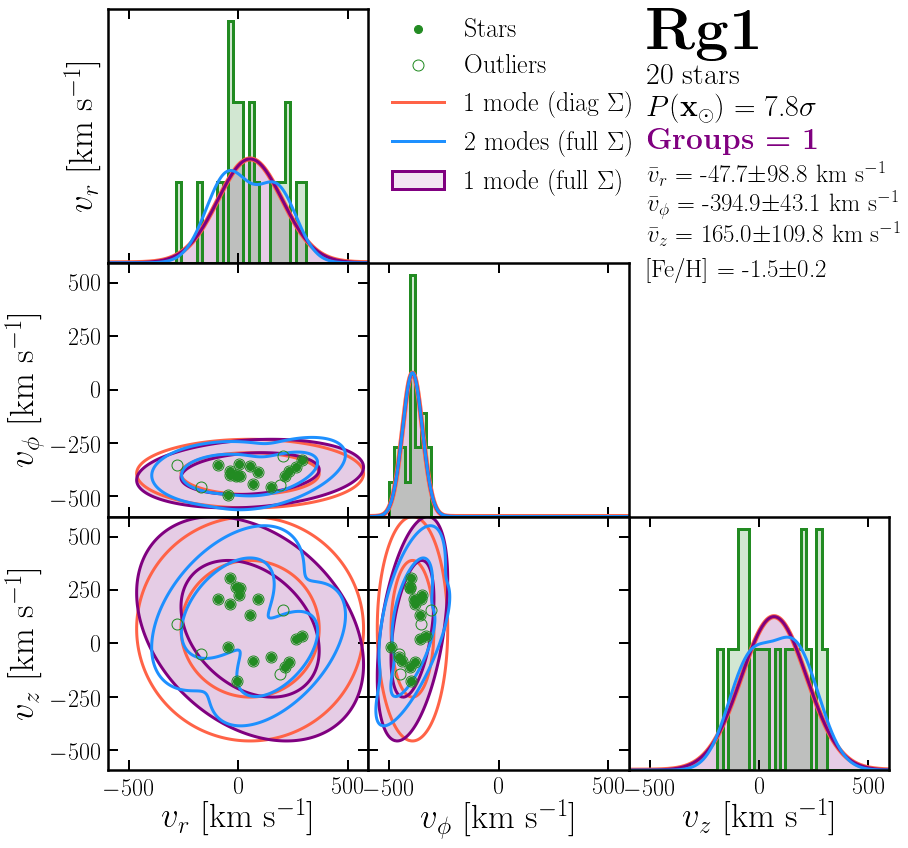

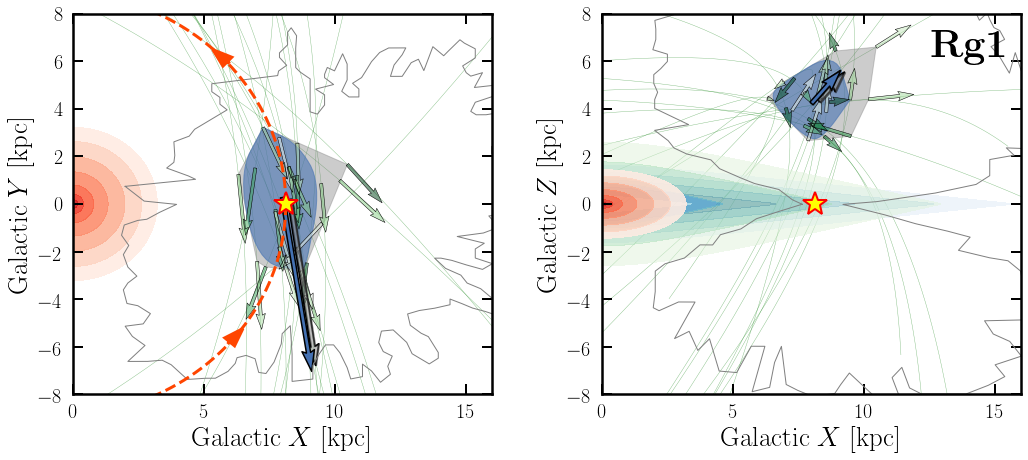

3


In [2]:
colsubs = flipud(cm.Spectral(linspace(0.0,1.0,num_cands)))
for i_cand in range(0,15):
    Cand = df.loc[df['group_id'] == names[i_cand]].reset_index()
    
    if names[i_cand]=='C2':
        Cand = Cand[(Cand.GalRVel<0)&(Cand.GalzVel>100)]
        
        
    fig = VelocityTriangle(Cand)
    plt.show()
    plt.close(fig)

    #fig = XY_XZ(Cand,StarsColour=colsubs[i_cand,:],Grid=False)
    #plt.show()
    #plt.close(fig)
    print i_cand

In [18]:
# Creating table for latex
nshards = shape(df_shards)[0]
names_str = [None]*nshards
v_str = [None]*nshards
sig_str = [None]*nshards
x_str = [None]*nshards
Psun_str = [None]*nshards
feh_str = [None]*nshards
pop_str = [None]*nshards

vx = df_shards.vx
vy = df_shards.vy
vz = df_shards.vz
sigx = df_shards.sigx
sigy = df_shards.sigy
sigz = df_shards.sigz
x = df_shards.x
y = df_shards.y
z = df_shards.z
feh = df_shards.feh
dfeh = df_shards.dfeh
pops = df_shards.population
Psun = df_shards.Psun

for i in range(0,nshards):
    namei = shard_names[i+1,0]
    if namei.endswith('b'):
        names_str[i] = namei
    else:
        names_str[i] = '\hline\hline '+namei
    x_str[i] = '$('+'{:.1f}'.format(x[i])+','+'{:.1f}'.format(y[i])+','+'{:.1f}'.format(z[i])+')$'
    v_str[i] = '$('+'{:.1f}'.format(vx[i])+','+'{:.1f}'.format(vy[i])+','+'{:.1f}'.format(vz[i])+')$'
    sig_str[i] = '$('+'{:.1f}'.format(sigx[i])+','+'{:.1f}'.format(sigy[i])+','+'{:.1f}'.format(sigz[i])+')$'
    feh_str[i] = '$'+'{:.1f}'.format(feh[i])+'\pm '+'{:.1f}'.format(dfeh[i])+'$'
    Psun_str[i] = '{:.1f}'.format(Psun[i])
    pop_str[i] = str(int(pops[i]))
    
    #if namei.endswith('b'):
    #    Psun_str[i] += '\hline'
columnsTitles = ['ID',
                 'No. stars',
                 '$(X,Y,Z)$ [kpc]',
                 '$(v_r,v_\phi,v_z)$',
                 '$(\sigma_r,\sigma_\phi,\sigma_z)$',
                 'Fe/H',
                'P']
df_str = pandas.DataFrame(
    {columnsTitles[0]:names_str,
     columnsTitles[1]:pop_str,
     columnsTitles[2]:x_str,
     columnsTitles[3]:v_str,
    columnsTitles[4]:sig_str,
    columnsTitles[5]:feh_str,
    columnsTitles[6]:Psun_str})
#df_str = pandas.DataFrame([x_str,v_str],columns=['Position','Velocity'])
df_str = df_str.reindex(columns=columnsTitles)
df_str.to_csv('../data/FitShards_text.csv',index=False)



In [17]:
print b'\hline\hline '+' {'+'\bf '+namei+'}'

\hline\hline  {f NCand29}


In [72]:
shape(shard_names)

(70, 1)

In [ ]:
fig = Orbits(Cand,xlim=16,ylim=16,zlim=16,T_Myr=40.0)
plt.show()
plt.close(fig)